In [50]:
import folium
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

from pandas import DataFrame, Series

from folium.plugins import HeatMap

from scipy.stats import f_oneway

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

sns.set(style="whitegrid")

In [51]:
df: DataFrame = pd.read_csv('data/moscow_apartment_listings.csv')
df.head()

price  repair  year_built_empty  house_age  closest_subway  \
0   8000000       3                 0         42              59   
1   7200000       2                 0         43              59   
2  10300000       2                 0         43              59   
3   8500000       2                 0         43              59   
4   9000000       2                 0         43              59   

   dist_to_subway   sg        lat        lon  subway_dist_to_center  ...  \
0             960  0.0  55.609009  37.734632                  17166  ...   
1             802  0.0  55.608760  37.741936                  17166  ...   
2             638  0.0  55.610207  37.742495                  17166  ...   
3             929  0.0  55.624017  37.740373                  17166  ...   
4             785  0.0  55.609107  37.740430                  17166  ...   

  subway_offers  address_offers  rooms  footage  floor  max_floor  \
0             5             1.0      1     39.4     11         12   
1             9             1.0      1     35.6      2          9   
2             9             2.0      2     53.0      5         12   
3             5             1.0      2     44.1      8          9   
4             5             1.0      2     44.2      6          9   

   first_floor  last_floor   AO     hm  
0            0           0  UAO  panel  
1            0           0  UAO  panel  
2            0           0  UAO  panel  
3            0           0  UAO  panel  
4            0           0  UAO  panel  

[5 rows x 22 columns]

## Проверка данных

In [52]:
# Проверка наличия пропущенных значений
missing_values: Series = df.isnull().sum()
df_info: DataFrame = df.info()
df_info = df.info()
missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12181 entries, 0 to 12180
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  12181 non-null  int64  
 1   repair                 12181 non-null  int64  
 2   year_built_empty       12181 non-null  int64  
 3   house_age              12181 non-null  int64  
 4   closest_subway         12181 non-null  int64  
 5   dist_to_subway         12181 non-null  int64  
 6   sg                     12181 non-null  float64
 7   lat                    12181 non-null  float64
 8   lon                    12181 non-null  float64
 9   subway_dist_to_center  12181 non-null  int64  
 10  h3                     12181 non-null  object 
 11  agent_offers           12181 non-null  int64  
 12  subway_offers          12181 non-null  int64  
 13  address_offers         12181 non-null  float64
 14  rooms                  12181 non-null  int64  
 15  fo

price                    0
repair                   0
year_built_empty         0
house_age                0
closest_subway           0
dist_to_subway           0
sg                       0
lat                      0
lon                      0
subway_dist_to_center    0
h3                       0
agent_offers             0
subway_offers            0
address_offers           0
rooms                    0
footage                  0
floor                    0
max_floor                0
first_floor              0
last_floor               0
AO                       0
hm                       0
dtype: int64

# Визуализация распределения ключевых переменных

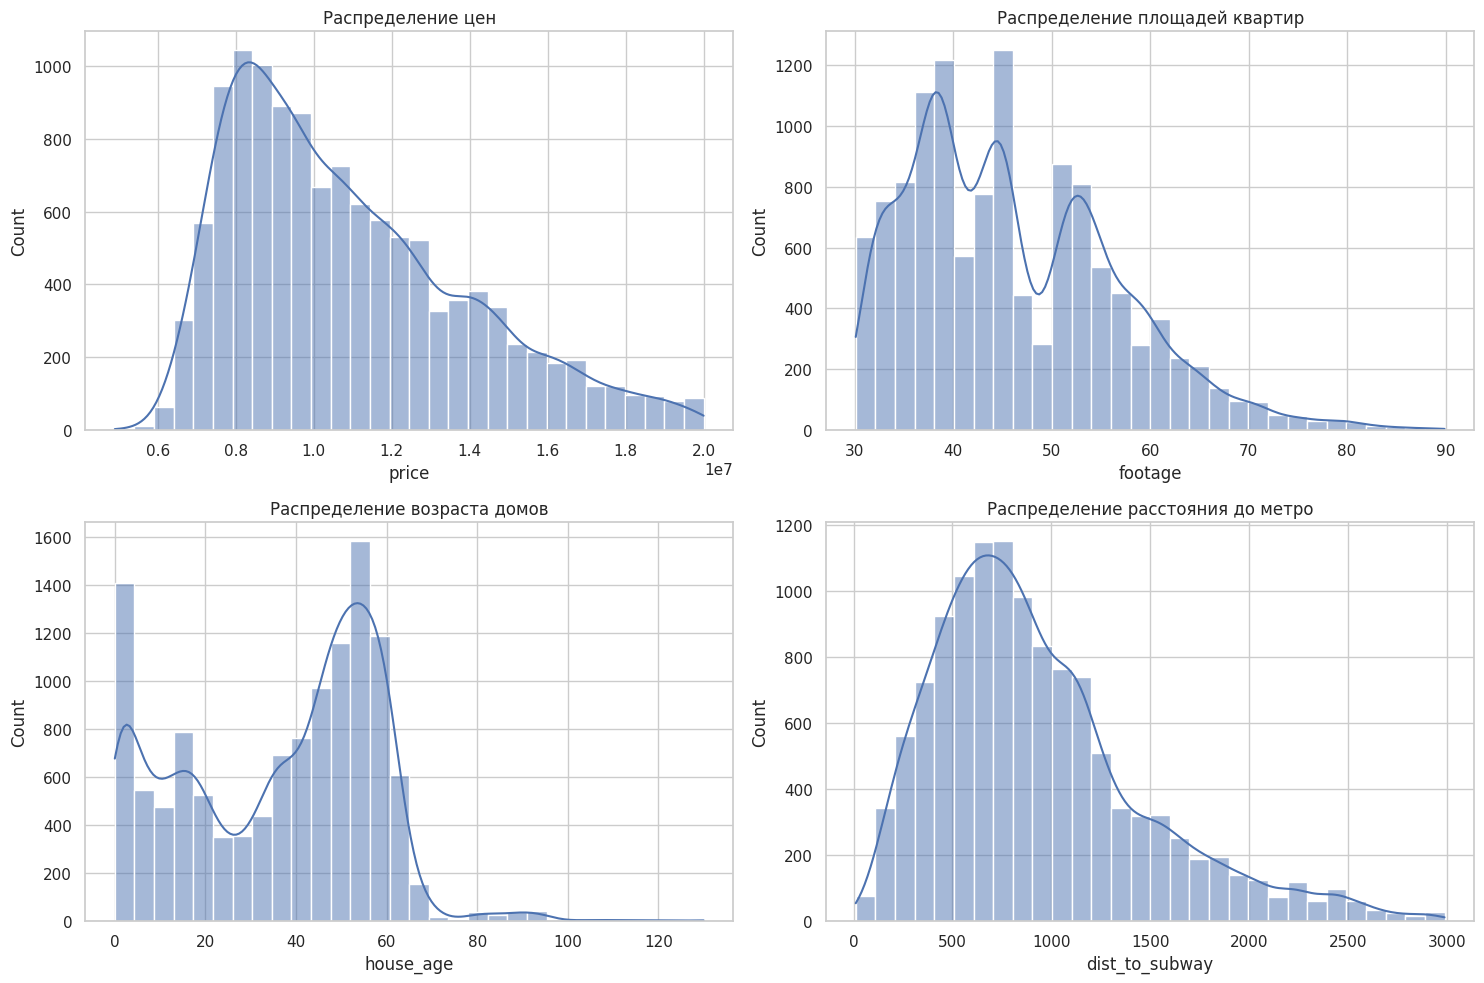

In [53]:
# Определение числовых колонок для анализа
numeric_columns = ['price', 'house_age', 'dist_to_subway', 'footage', 'floor', 'max_floor']

# Создание фигуры для графиков
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Гистограммы и диаграммы ящика с усами для каждой из ключевых переменных
sns.histplot(df['price'], bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Распределение цен')

sns.histplot(df['footage'], bins=30, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Распределение площадей квартир')

sns.histplot(df['house_age'], bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Распределение возраста домов')

sns.histplot(df['dist_to_subway'], bins=30, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Распределение расстояния до метро')

plt.tight_layout()
plt.show()

#### Вывод:
    Распределение цен: Распределение цен на квартиры имеет правостороннюю асимметрию, что является довольно типичным для рынка недвижимости. Большинство квартир сконцентрировано в более низком ценовом диапазоне, но есть и дорогие объекты, которые выделяются.

    Распределение площадей квартир: Площадь квартир также имеет правостороннюю асимметрию. Большинство квартир имеют площадь около 40-60 квадратных метров, но есть и квартиры с гораздо большей площадью.

    Распределение возраста домов: Возраст домов распределен более равномерно, хотя можно заметить, что домов старше 50 лет несколько меньше, чем более новых зданий.

    Распределение расстояния до метро: Расстояние до метро показывает, что большинство квартир находится на расстоянии до 1500 метров от ближайшей станции, что свидетельствует о хорошей доступности транспортной инфраструктуры.

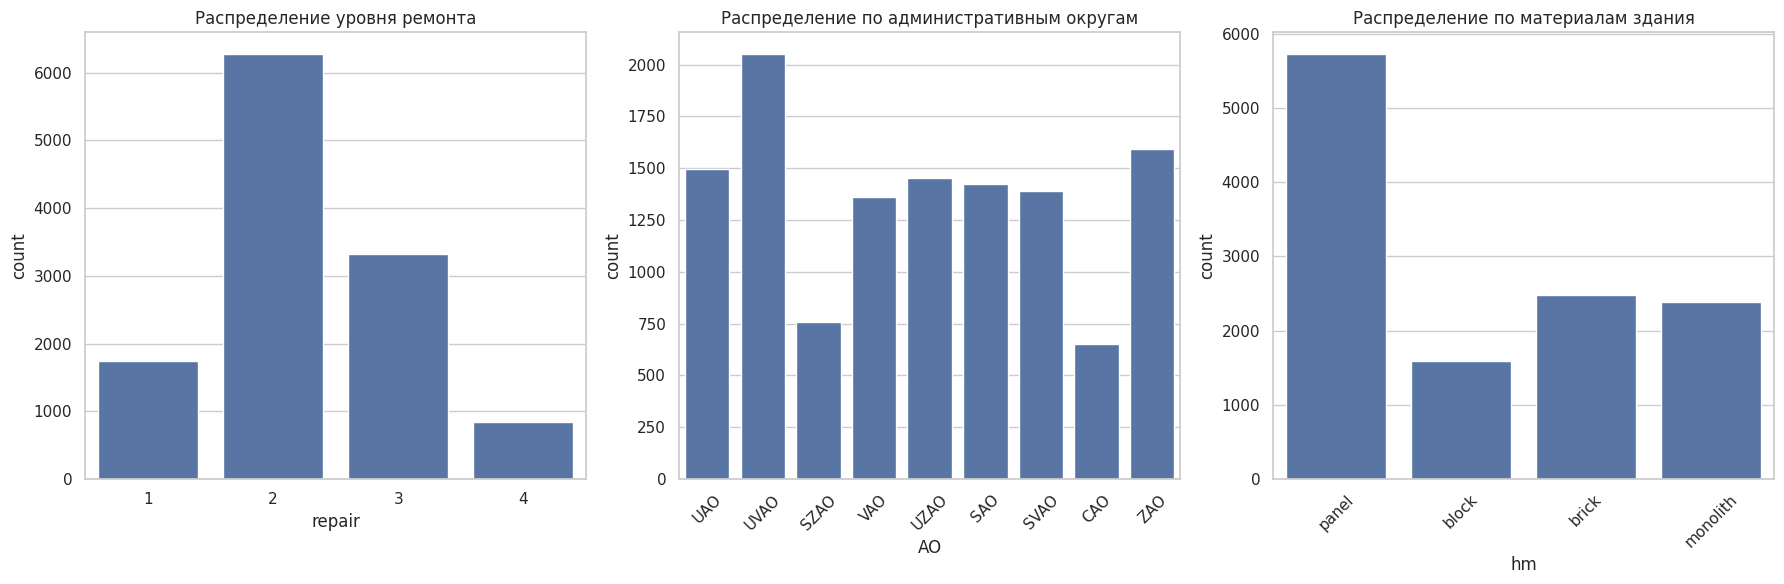

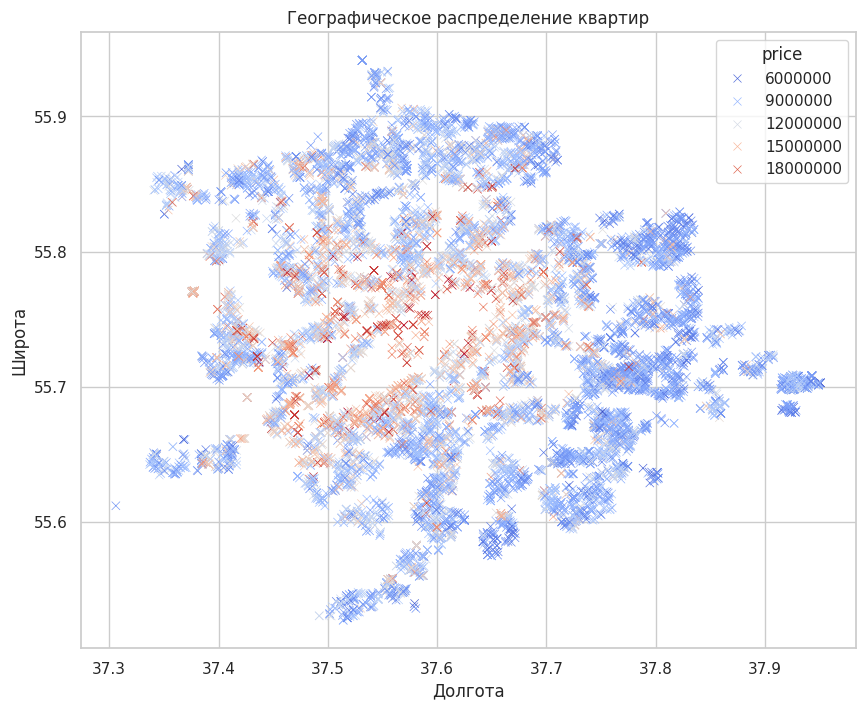

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Столбчатая диаграмма для уровня ремонта
sns.countplot(x='repair', data=df, ax=axs[0])
axs[0].set_title('Распределение уровня ремонта')

# Столбчатая диаграмма для административного округа
sns.countplot(x='AO', data=df, ax=axs[1])
axs[1].set_title('Распределение по административным округам')
axs[1].tick_params(axis='x', rotation=45)

# Столбчатая диаграмма для материала здания
sns.countplot(x='hm', data=df, ax=axs[2])
axs[2].set_title('Распределение по материалам здания')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Визуализация географического распределения
plt.figure(figsize=(10, 8))
sns.scatterplot(x='lon', y='lat', hue='price', palette='coolwarm', data=df, marker='x')
plt.title('Географическое распределение квартир')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

    Распределение уровня ремонта: Большинство квартир имеют средний уровень ремонта (2 и 3). Квартир с самым высоким уровнем ремонта (4) значительно меньше.

    Распределение по административным округам: Наблюдается различное количество предложений по разным округам. Некоторые округа представлены более широко, что может быть связано как с размерами округа, так и с активностью рынка недвижимости в этих районах.

    Распределение по материалам здания: Большинство зданий построено из панели и кирпича, что является типичным для Москвы. Другие материалы представлены в меньшем количестве.

    Географическое распределение квартир: На карте видно, что квартиры распределены по всей Москве. Цветовая кодировка показывает цену квартир, где более тёплые цвета соответствуют более высоким ценам. Можно заметить, что более высокие цены чаще встречаются в центральных районах города.

#### Визуализация данных на карте

In [55]:
map_moscow = folium.Map(location=[55.7558, 37.6173], zoom_start=10)  # координаты центра Москвы

# Подготовка данных для тепловой карты
heat_data = [[row['lat'], row['lon'], row['price']] for index, row in df.iterrows()]

HeatMap(heat_data).add_to(map_moscow)

map_moscow.save('web/moscow_heatmap.html')
map_moscow

In [56]:
translation_dict = {
    'UVAO': 'Юго-Восточный',
    'ZAO': 'Западный',
    'UAO': 'Южный',
    'UZAO': 'Юго-Западный',
    'SAO' : 'Северный',
    'SVAO' : 'Северо-Восточный',
    'VAO' : 'Восточный',
    'SZAO' : 'Северо-Западный',
    'CAO' : 'Центральный',
}

geo_path = 'data/ao.geojson'
with open(geo_path) as f:
    geo_data = json.load(f)

df_copy = df.copy()
df_copy['AO'] = df_copy['AO'].map(translation_dict)

average_prices = df_copy.groupby('AO')['price'].mean().reset_index()
average_prices.rename(columns={'AO': 'NAME', 'price': 'average_price'}, inplace=True)
    
map_moscow = folium.Map(location=[55.7558, 37.6173], zoom_start=10)

folium.Choropleth(
    geo_data=geo_data,
    name='choropleth',
    data=average_prices,
    columns=['NAME', 'average_price'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Средняя цена недвижимости по округам'
).add_to(map_moscow)

folium.LayerControl().add_to(map_moscow)

map_moscow.save('web/moscow_avg_price.html')
map_moscow

## Описательный анализ

### Просмотр основных статических показателей

In [57]:
df_description = df.describe()
df_description

price        repair  year_built_empty     house_age  \
count  1.218100e+04  12181.000000      12181.000000  12181.000000   
mean   1.086987e+07      2.267302          0.013710     36.360644   
std    3.037320e+06      0.787196          0.116289     21.406406   
min    4.900000e+06      1.000000          0.000000      0.000000   
25%    8.500000e+06      2.000000          0.000000     17.000000   
50%    1.020000e+07      2.000000          0.000000     42.000000   
75%    1.270000e+07      3.000000          0.000000     54.000000   
max    2.000000e+07      4.000000          1.000000    130.000000   

       closest_subway  dist_to_subway            sg           lat  \
count    12181.000000    12181.000000  12181.000000  12181.000000   
mean       100.585009      928.353748      0.242673     55.738639   
std         56.707817      532.443508      0.629897      0.087598   
min          0.000000       11.000000      0.000000     55.527631   
25%         55.000000      548.000000      0.000000     55.674840   
50%        103.000000      820.000000      0.000000     55.730855   
75%        149.000000     1177.000000      0.000000     55.806115   
max        199.000000     2988.000000      3.000000     55.941577   

                lon  subway_dist_to_center  agent_offers  subway_offers  \
count  12181.000000           12181.000000  12181.000000   12181.000000   
mean      37.618241           11938.048026     25.429932      10.176915   
std        0.134112            4711.729983     61.837916       7.078888   
min       37.306055            1133.000000      0.000000       1.000000   
25%       37.520435            8635.000000      1.000000       5.000000   
50%       37.604411           12418.000000      1.000000       8.000000   
75%       37.720789           14800.000000     11.000000      13.000000   
max       37.950668           24636.000000    292.000000      40.000000   

       address_offers         rooms       footage         floor     max_floor  \
count    12181.000000  12181.000000  12181.000000  12181.000000  12181.000000   
mean         1.290124      1.603973     46.153803      6.867334     13.449306   
std          0.730561      0.489090     10.543171      5.313950      6.413437   
min          1.000000      1.000000     30.100000      1.000000      2.000000   
25%          1.000000      1.000000     38.000000      3.000000      9.000000   
50%          1.000000      2.000000     44.500000      5.000000     12.000000   
75%          1.000000      2.000000     53.400000      9.000000     17.000000   
max          9.000000      2.000000     89.900000     38.000000     39.000000   

        first_floor    last_floor  
count  12181.000000  12181.000000  
mean       0.104671      0.094409  
std        0.306142      0.292409  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

#### Микровывод:
    Цена (price): Средняя цена квартиры составляет примерно 10.87 миллиона рублей, со стандартным отклонением 3.04 миллиона рублей. Минимальная цена - 4.9 миллиона рублей, максимальная - 20 миллионов рублей.

    Состояние ремонта (repair): Среднее значение состояния ремонта близко к 2, что указывает на то, что большинство квартир имеют среднее качество ремонта.

    Возраст дома (house_age): Средний возраст дома составляет около 36 лет, со стандартным отклонением в 21 год.

    Расстояние до метро (dist_to_subway): В среднем квартиры находятся на расстоянии около 928 метров от метро.

    Площадь квартир (footage): Средняя площадь квартиры составляет около 46 квадратных метров.

    Этаж (floor) и максимальное количество этажей (max_floor): Средний этаж, на котором расположена квартира, - это 7-й этаж, при этом в здании в среднем 13 этажей.

    Количество комнат (rooms): Большинство квартир имеют 1 или 2 комнаты.

### Проведем корреляционный анализ

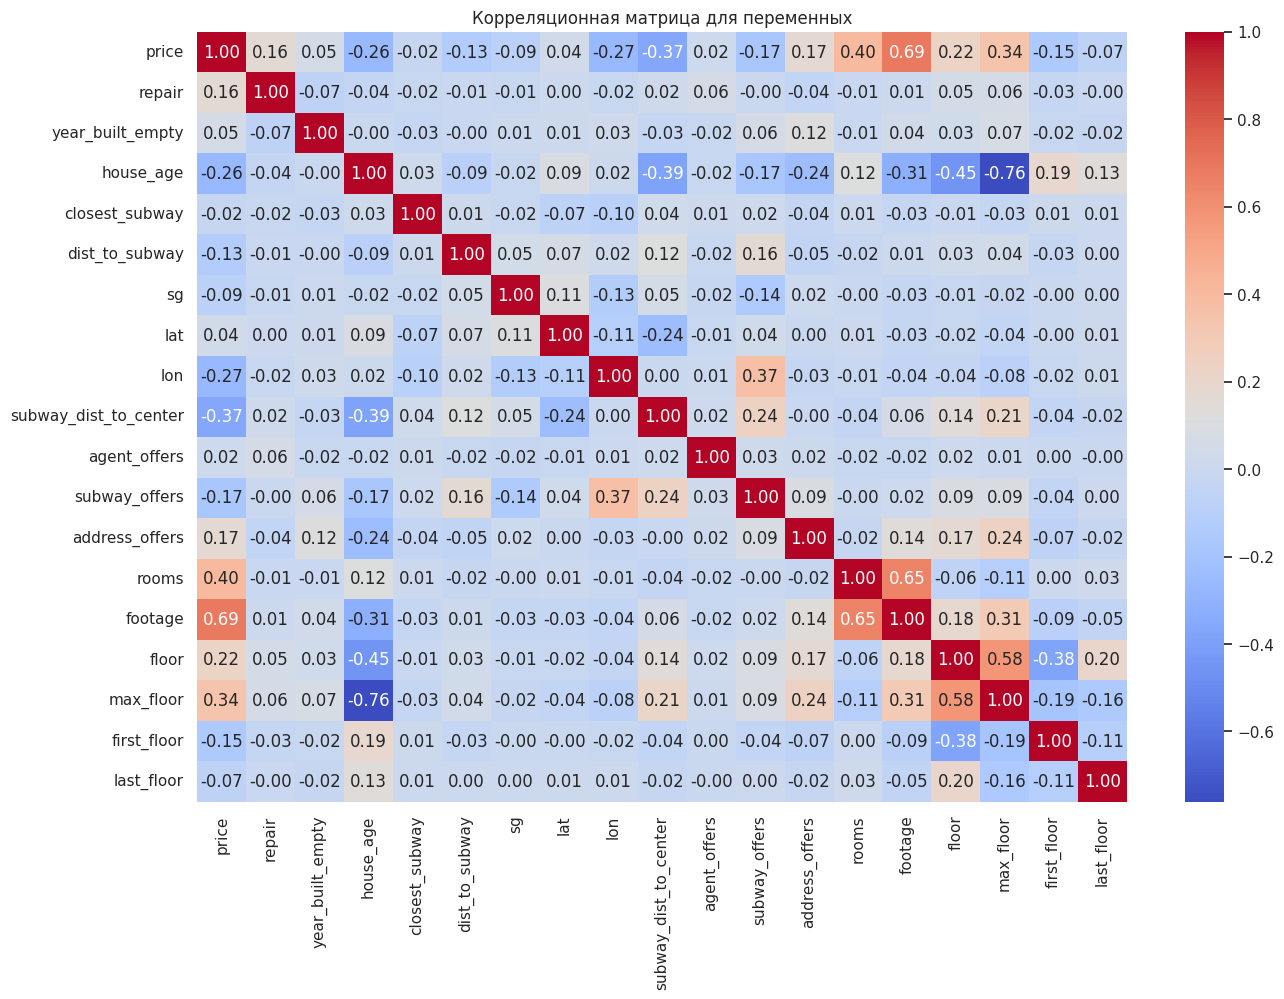

In [58]:
correlation_df: DataFrame = df_copy.drop(['AO', 'hm', 'h3'], axis=1)

# Вычисление коэффициентов корреляции
correlation_matrix:float = correlation_df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица для переменных')
plt.show()

На тепловой карте корреляционной матрицы представлены коэффициенты корреляции Пирсона между различными переменными в нашем датасете. Вот некоторые ключевые наблюдения:

    Корреляция с ценой (price):
        Площадь квартиры (footage) имеет сильную положительную корреляцию с ценой. Это означает, что с увеличением площади квартиры, как правило, увеличивается и её цена.
        Количество комнат (rooms) также положительно коррелирует с ценой, что логично, так как больше комнат обычно означает большую площадь.
        Расстояние до метро (dist_to_subway) имеет отрицательную корреляцию с ценой, что может указывать на то, что квартиры, расположенные ближе к метро, стоят дороже.

    Другие интересные корреляции:
        Возраст дома (house_age) имеет отрицательную корреляцию с ценой, что может говорить о том, что более новые квартиры стоят дороже.
        Этаж (floor) и максимальный этаж в здании (max_floor) имеют положительную корреляцию, что может отражать предпочтения покупателей квартир на более высоких этажах.

### Анализ распределения переменных

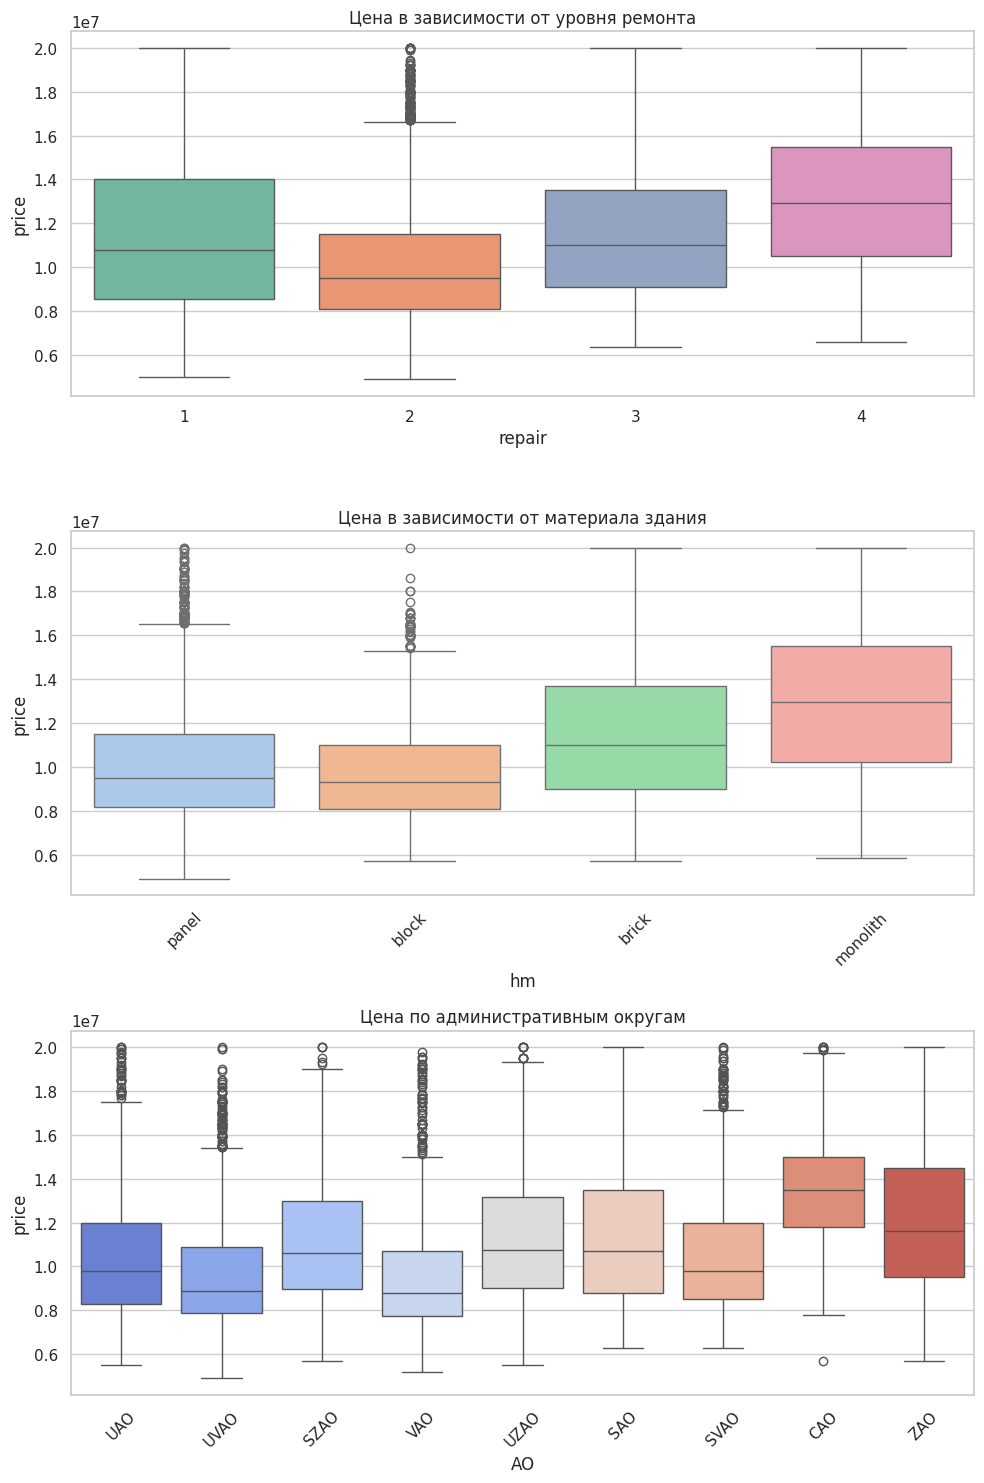

In [59]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Ящик с усами для уровня ремонта с цветовой схемой
sns.boxplot(x='repair', y='price', data=df, hue='repair', palette='Set2', ax=axs[0], legend=False)
axs[0].set_title('Цена в зависимости от уровня ремонта')

# Ящик с усами для материала здания с цветовой схемой
sns.boxplot(x='hm', y='price', data=df, hue='hm', palette='pastel', ax=axs[1], legend=False)
axs[1].set_title('Цена в зависимости от материала здания')
axs[1].tick_params(axis='x', rotation=45)

# Ящик с усами для административного округа с цветовой схемой
sns.boxplot(x='AO', y='price', data=df, hue='AO', palette='coolwarm', ax=axs[2], legend=False)
axs[2].set_title('Цена по административным округам')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Микровывод:
    Цена в зависимости от уровня ремонта (repair):
        С увеличением уровня ремонта (от 1 до 4) наблюдается повышение медианной цены квартиры. Это указывает на то, что более высокий уровень ремонта обычно связан с более высокой стоимостью недвижимости.
        Есть выбросы во всех категориях, особенно в категориях с более высоким уровнем ремонта, что может указывать на наличие особо дорогих квартир с высококачественным ремонтом.

    Цена в зависимости от материала здания (hm):
        Цены на квартиры в различных типах зданий имеют различное распределение. Например, кирпичные и монолитные дома часто имеют более высокую медианную цену по сравнению с панельными и блочными.
        Также здесь присутствуют выбросы, особенно в категориях монолитных и кирпичных домов, что может говорить о наличии особо дорогих квартир в этих типах зданий.

    Цена по административным округам (AO):
        Цены на недвижимость значительно варьируются в зависимости от административного округа. Например, в Центральном округе (ЦАО) медианная цена значительно выше, чем в других округах, что отражает высокую стоимость недвижимости в центре города.
        В других округах распределение цен более равномерное, хотя также присутствуют выбросы, указывающие на наличие исключительно дорогих объектов.

##### Многомерный анализ

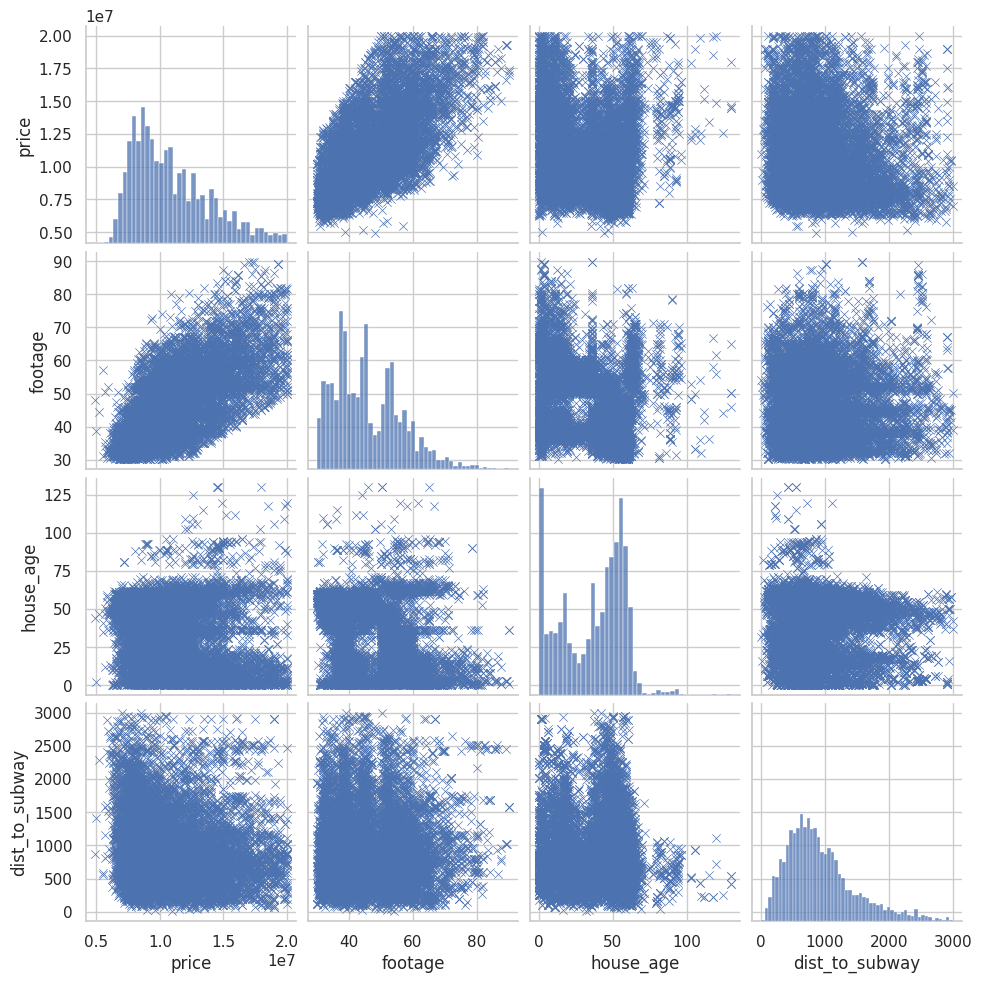

In [60]:
selected_columns = ['price', 'footage', 'house_age', 'dist_to_subway']
pairplot_data = df[selected_columns]

sns.pairplot(pairplot_data, markers='x')
plt.show()

    Цена и площадь квартиры (footage): Существует положительная корреляция между ценой и площадью квартиры, что ожидаемо, так как большие квартиры обычно стоят дороже.

    Цена и возраст дома (house_age): Возможно, имеется слабая отрицательная корреляция, что может указывать на то, что новые дома стоят дороже старых. Однако эта тенденция не является очень явной.

    Цена и расстояние до метро (dist_to_subway): Не наблюдается явной корреляции, что может свидетельствовать о том, что расстояние до метро не является основным фактором в определении цены, или что его влияние перекрывается другими факторами.     

#### Cтатистического анализа категориальных переменных

In [61]:
anova_repair = f_oneway(
    df[df['repair'] == 1]['price'],
    df[df['repair'] == 2]['price'],
    df[df['repair'] == 3]['price'],
    df[df['repair'] == 4]['price']
)

# ANOVA для материала здания
hm_groups = df.groupby('hm')['price'].apply(list)
anova_hm = f_oneway(*hm_groups)

# ANOVA для административного округа
ao_groups = df.groupby('AO')['price'].apply(list)
anova_ao = f_oneway(*ao_groups)

anova_repair, anova_hm, anova_ao

(F_onewayResult(statistic=418.749151197426, pvalue=6.494908713152746e-259),
 F_onewayResult(statistic=731.7142268965031, pvalue=0.0),
 F_onewayResult(statistic=207.67337881740875, pvalue=0.0))

    Уровень ремонта (repair):
        Статистика F = 418.75
        p-значение < 0.001
        Это указывает на наличие статистически значимых различий в ценах между разными уровнями ремонта.

    Материал здания (hm):
        Статистика F = 731.71
        p-значение < 0.001
        Это также указывает на наличие статистически значимых различий в ценах для разных материалов здания.

    Административный округ (AO):
        Статистика F = 207.67
        p-значение < 0.001
        Это говорит о том, что цены значительно различаются в зависимости от административного округа.

### Анализ категориальных переменных

In [62]:
categorical_columns = ['h3', 'AO', 'hm', 'year_built_empty']

categorical_analysis = {col: df[col].value_counts() for col in categorical_columns}

categorical_analysis

{'h3': h3
 8611aa6a7ffffff    671
 8611aa7b7ffffff    602
 8611aa70fffffff    581
 8611aa717ffffff    544
 861181b6fffffff    534
 8611aa707ffffff    511
 8611aa787ffffff    500
 8611aa6b7ffffff    497
 8611aa637ffffff    473
 8611aa78fffffff    469
 8611aa71fffffff    456
 8611aa627ffffff    453
 8611aa797ffffff    401
 8611aa45fffffff    394
 8611aa68fffffff    351
 8611aa7a7ffffff    351
 8611aa617ffffff    329
 8611aa79fffffff    319
 8611aa4dfffffff    316
 861181b67ffffff    316
 8611aa7afffffff    311
 8611aa44fffffff    286
 8611aa6afffffff    273
 8611aa61fffffff    262
 8611aa737ffffff    217
 8611aa4cfffffff    212
 8611aa687ffffff    197
 8611aa727ffffff    188
 8611aa457ffffff    185
 8611aa607ffffff    177
 8611aa4efffffff    170
 8611aa09fffffff    119
 8611aa777ffffff    112
 8611aa72fffffff     92
 8611aa757ffffff     90
 8611aa46fffffff     63
 861181b4fffffff     54
 8611aa447ffffff     43
 8611aa69fffffff     38
 8611aa62fffffff     10
 8611aa4d7ffffff      6
 86118

#### Микровывод:
    h3 (Географическое разбиение):
        Эта переменная имеет множество уникальных значений, что указывает на детализированное географическое разделение.

    AO (Административный округ):
        Видно, что квартиры распределены неравномерно по административным округам. Например, в округах UVAO и ZAO квартир в продаже больше, чем в других округах.

    hm (Тип здания):
        Большинство квартир расположены в панельных домах, за ними следуют кирпичные, монолитные и блочные дома. Это распределение может влиять на цену квартир.

    year_built_empty (Наличие данных о годе постройки):
        В подавляющем большинстве случаев данные о годе постройки имеются.

## Предобработка данных

### Очистка данных от выбросов

In [63]:
# def remove_useless_information(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# print(f"Before {df.shape[0]}")
# for column in numeric_columns:
#     df = remove_useless_information(df, column)
# print(f"After {df.shape[0]}")

# df.describe()

### Кодирование Категориальных Переменных

    One-Hot Encoding: Преобразует категориальные переменные в набор бинарных столбцов, каждый из которых указывает на присутствие или отсутствие каждой возможной категории. Это подходит для переменных с небольшим числом уникальных категорий.

    Label Encoding: Присваивает каждой уникальной категории числовой метки. Это эффективно для переменных с большим количеством категорий, где one-hot encoding может привести к слишком большому увеличению размерности.

#### Рассмотрим каждую переменную:

    h3: Учитывая большое количество уникальных значений, предпочтительнее использовать Label Encoding.
    AO: Количество уникальных значений умеренное, можно использовать One-Hot Encoding.
    hm: Также подходит для One-Hot Encoding.
    year_built_empty: Учитывая только два уникальных значения, можно использовать One-Hot Encoding или просто оставить как бинарный столбец.

In [64]:
# label_encoder = LabelEncoder()
# # df['h3_encoded'] = label_encoder.fit_transform(df['h3'])
# df['h3'] = label_encoder.fit_transform(df['h3'])

# # One-Hot Encoding для 'AO', 'hm', и 'year_built_empty'
# df = pd.get_dummies(df, columns=['AO', 'hm', 'year_built_empty'])

# df.head()

## Обучения и оценки модели

#### Разделение данных на обучающую и тестовую выборку

In [65]:
X = df.drop('price', axis=1)
y = df['price']

# Определение категориальных и числовых столбцов
categorical_cols = ['repair', 'AO', 'hm']  # Категориальные переменные
numerical_cols = [col for col in X.columns if col not in categorical_cols + ['h3', 'year_built_empty']]  # Числовые переменные

# Предобработка для числовых данных
numerical_transformer = StandardScaler()

# Предобработка для категориальных данных
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Сборка конвейера
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Создание конвейера, включающего предобработку и модель
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Подготовка данных с помощью конвейера
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

#### <b>Этап моделирования и оценки модели</b>

<b>Реализуем три модели</b>

    Линейная регрессия (Linear Regression): Базовая и часто используемая модель для регрессионных задач.
    Случайный лес (Random Forest Regression): Модель, которая строит множество решающих деревьев и выдает средний результат их прогнозов.

    Градиентный бустинг (Gradient Boosting Regression): Модель последовательно строит решающие деревья, каждое из которых участвует в корректировке ошибок предыдущих деревьев.

MSE в ML означает среднеквадратичную ошибку (mean squared error), которая является метрикой регрессии, измеряющей среднюю квадратичную разницу между фактическими и прогнозируемыми значениями. MSE показывает, насколько хорошо модель соответствует данным, и чем ниже MSE, тем лучше модель.

In [66]:
# models = {
#     "Linear Regression": LinearRegression(),
#     "Random Forest": RandomForestRegressor(random_state=42),
#     "Gradient Boosting": GradientBoostingRegressor(random_state=42)
# }

# for name, model in models.items():
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
#     mse = mean_squared_error(y_test, predictions)
#     print(f"{name}: MSE = {mse}")
linear_model = LinearRegression()
linear_model.fit(X_train_prepared, y_train)

# Случайный лес
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train_prepared, y_train)

# Градиентный бустинг
gb_model = GradientBoostingRegressor(random_state=0)
gb_model.fit(X_train_prepared, y_train)

GradientBoostingRegressor(random_state=0)

In [67]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 4, 5]
# }

# # Создание модели градиентного бустинга
# gb = GradientBoostingRegressor(random_state=42)

# # Поиск лучших параметров с помощью GridSearchCV
# grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

# grid_search.fit(X_train, Y_train)

# # Лучшие параметры и соответствующая ошибка
# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# print(f"Лучшие параметры: {best_params}")
# print(f"Лучшая MSE: {best_score}")

def evaluate_model(model, X_test_prepared, y_test):
    y_pred = model.predict(X_test_prepared)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

# Оценка моделей
linear_mae, linear_mse, linear_r2 = evaluate_model(linear_model, X_test_prepared, y_test)
rf_mae, rf_mse, rf_r2 = evaluate_model(rf_model, X_test_prepared, y_test)
gb_mae, gb_mse, gb_r2 = evaluate_model(gb_model, X_test_prepared, y_test)

# Печать результатов
print("Линейная регрессия:", linear_mae, linear_mse, linear_r2)
print("Случайный лес:", rf_mae, rf_mse, rf_r2)
print("Градиентный бустинг:", gb_mae, gb_mse, gb_r2)

Линейная регрессия: 960888.2849061044 1639488173476.164 0.818870204692579
Случайный лес: 719282.0317148329 1023959734712.9011 0.8868734644432704
Градиентный бустинг: 852019.3452673162 1323454775834.3472 0.853785409054072


In [68]:
# best_gb_model = grid_search.best_estimator_
# predictions = best_gb_model.predict(X_test)

# mse = mean_squared_error(Y_test, predictions)

# print(f"MSE на тестовой выборке: {mse}")

# plt.figure(figsize=(10, 6))

# # Фактические цены
# plt.scatter(Y_test, Y_test, alpha=0.6, color='blue', label='Фактические Цены')

# # Предсказанные цены
# plt.scatter(Y_test, predictions, alpha=0.6, color='red', label='Предсказанные Цены')

# plt.xlabel('Фактические Цены')
# plt.ylabel('Цены')
# plt.title('Фактические vs Предсказанные Цены')
# plt.legend()
# plt.show()

def evaluate_model(model, X_test_prepared, y_test):
    y_pred = model.predict(X_test_prepared)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

# Оценка моделей
linear_mae, linear_mse, linear_r2 = evaluate_model(linear_model, X_test_prepared, y_test)
rf_mae, rf_mse, rf_r2 = evaluate_model(rf_model, X_test_prepared, y_test)
gb_mae, gb_mse, gb_r2 = evaluate_model(gb_model, X_test_prepared, y_test)

# Печать результатов
print("Линейная регрессия:", linear_mae, linear_mse, linear_r2)
print("Случайный лес:", rf_mae, rf_mse, rf_r2)
print("Градиентный бустинг:", gb_mae, gb_mse, gb_r2)

Линейная регрессия: 960888.2849061044 1639488173476.164 0.818870204692579
Случайный лес: 719282.0317148329 1023959734712.9011 0.8868734644432704
Градиентный бустинг: 852019.3452673162 1323454775834.3472 0.853785409054072


    Случайный лес показал лучшие результаты по всем трём метрикам: наименьшая ошибка (MAE и MSE) и наибольший коэффициент детерминации (R²). Это указывает на его высокую эффективность в предсказании цен на недвижимость для данного набора данных.
    Градиентный бустинг также показал хорошие результаты, но немного уступает случайному лесу.
    Линейная регрессия показала наихудшую производительность по сравнению с другими моделями. Это может быть связано с линейной природой модели, которая может не справляться с более сложными взаимосвязями в данных.

#### Настройка гиперпараметров

In [69]:
rf = RandomForestRegressor(random_state=0)

# Определение параметров для настройки
param_grid = {
    'n_estimators': [100, 200, 300],  # Количество деревьев
    'max_features': ['auto', 'sqrt'],  # Количество признаков для поиска лучшего разделения
    'max_depth': [10, 20, 30],        # Максимальная глубина деревьев
    'min_samples_split': [2, 5, 10]   # Минимальное количество образцов, необходимых для разделения узла
}

# Создание и выполнение поиска по сетке
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train_prepared, y_train)

# Лучшие параметры и лучшая модель
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Лучшие параметры:", best_params)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END max_depth=10, max_features=auto, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=

/home/likimiad/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
81 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
41 fits failed with the following error:
Traceback (most recent call last):
  File "/home/likimiad/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/likimiad/.local/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/likimiad/.local/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/home/liki

Лучшие параметры: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}


Теперь у вас есть лучшие параметры для модели случайного леса (RandomForestRegressor), полученные с помощью настройки гиперпараметров:

    max_depth: 30
    max_features: 'sqrt'
    min_samples_split: 2
    n_estimators: 300

In [70]:
best_rf_model = RandomForestRegressor(
    max_depth=30, 
    max_features='sqrt', 
    min_samples_split=2, 
    n_estimators=300,
    random_state=0
)

# Обучение модели
best_rf_model.fit(X_train_prepared, y_train)

# Предсказание на тестовой выборке
y_pred = best_rf_model.predict(X_test_prepared)

# Оценка производительности
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Среднеквадратичная ошибка (MSE):", mse)
print("Коэффициент детерминации (R²):", r2)

Средняя абсолютная ошибка (MAE): 716289.2832484747
Среднеквадратичная ошибка (MSE): 971421808730.2388
Коэффициент детерминации (R²): 0.8926778270078013


    Улучшение по сравнению с первоначальными моделями: Настроенная модель случайного леса показывает улучшение по сравнению с результатами, полученными до настройки гиперпараметров. Это видно как в уменьшении ошибок (MAE и MSE), так и в увеличении коэффициента детерминации (R²).

    Коэффициент детерминации (R²): Значение R², близкое к 0.9, указывает на то, что модель хорошо объясняет вариабельность целевой переменной, что является показателем хорошей производительности модели.

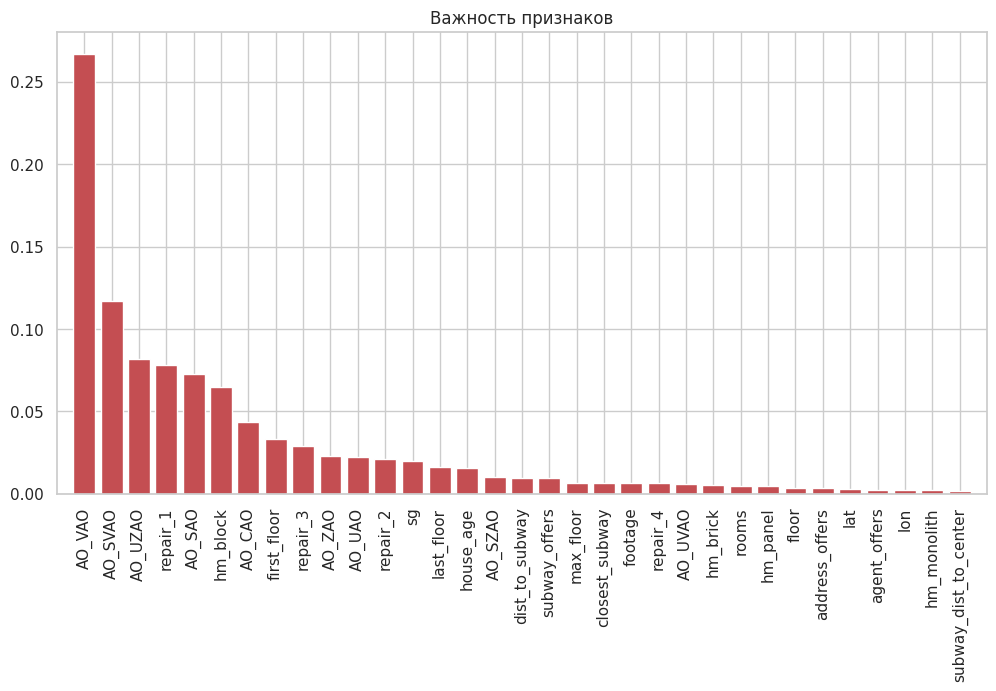

In [71]:
feature_importances = best_rf_model.feature_importances_

# Подготовка названий признаков
feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
feature_names += numerical_cols

# Сортировка признаков по важности
indices = np.argsort(feature_importances)[::-1]

# Визуализация важности признаков
plt.figure(figsize=(12, 6))
plt.title("Важность признаков")
plt.bar(range(X_train_prepared.shape[1]), feature_importances[indices],
        color="r", align="center")
plt.xticks(range(X_train_prepared.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train_prepared.shape[1]])
plt.show()

#### Попробуем расширить гиперпараметры

In [72]:
rf = RandomForestRegressor(random_state=0)

# Определение сетки параметров для поиска
param_distributions = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_features': ['auto', 'sqrt'],
    'max_depth': np.arange(10, 101, 10),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_distributions, n_iter=100, cv=3, verbose=2, random_state=0, n_jobs=-1)
random_search.fit(X_train_prepared, y_train)

# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.0s
[CV] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   0.0s
[CV] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   0.0s
[CV] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estima

/home/likimiad/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=  16.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   9.5s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=  15.6s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=  11.3s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=  11.7s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   7.7s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=  15.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  11.4s
[CV] END max_depth=30, max_features=s

/home/likimiad/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
147 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
58 fits failed with the following error:
Traceback (most recent call last):
  File "/home/likimiad/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/likimiad/.local/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/likimiad/.local/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/home/lik

Лучшие параметры: {'n_estimators': 900, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


#### Использование ансамблевых методов

In [73]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=0)
xgb_model.fit(X_train_prepared, y_train)

# Предсказание и оценка
xgb_pred = xgb_model.predict(X_test_prepared)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost MAE:", xgb_mae)
print("XGBoost MSE:", xgb_mse)
print("XGBoost R²:", xgb_r2)

XGBoost MAE: 794924.6241280263
XGBoost MSE: 1148697436169.6597
XGBoost R²: 0.8730925084732887


Определили лучшие параметры для случайного леса: 'n_estimators': 900, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30. 

Для XGBoost показывают, что модель достигла коэффициента детерминации R² = 0.873, что является хорошим показателем. 

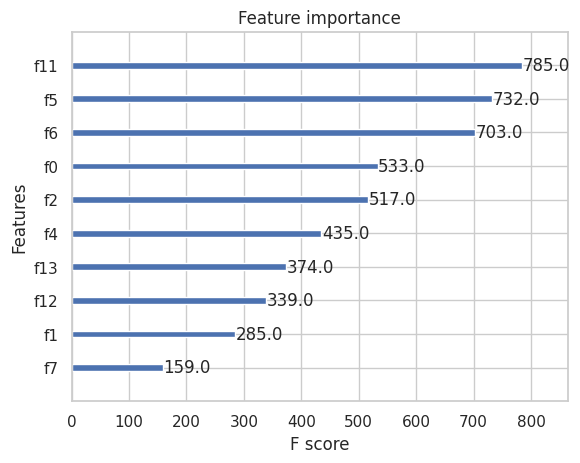

In [74]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

In [75]:
feature_names = preprocessor.get_feature_names_out()
fscore = xgb_model.get_booster().get_fscore()
index_to_feature = {f"f{i}": name for i, name in enumerate(feature_names)}

# Вывод важности признаков с их реальными названиями
for feature_idx, importance in fscore.items():
    feature_name = index_to_feature[feature_idx]
    print(f"{feature_name}: {importance}")

num__house_age: 533.0
num__closest_subway: 285.0
num__dist_to_subway: 517.0
num__sg: 76.0
num__lat: 435.0
num__lon: 732.0
num__subway_dist_to_center: 703.0
num__agent_offers: 159.0
num__subway_offers: 147.0
num__address_offers: 33.0
num__rooms: 22.0
num__footage: 785.0
num__floor: 339.0
num__max_floor: 374.0
num__last_floor: 9.0
cat__repair_1: 95.0
cat__repair_2: 41.0
cat__repair_3: 120.0
cat__repair_4: 134.0
cat__AO_CAO: 64.0
cat__AO_SAO: 10.0
cat__AO_SVAO: 4.0
cat__AO_SZAO: 4.0
cat__AO_UAO: 16.0
cat__AO_UVAO: 52.0
cat__AO_UZAO: 48.0
cat__AO_VAO: 5.0
cat__AO_ZAO: 12.0
cat__hm_block: 20.0
cat__hm_brick: 29.0
cat__hm_monolith: 61.0
cat__hm_panel: 36.0


    Признаки, связанные с характеристиками квартиры:
        num__footage (общая площадь квартиры) имеет наивысшую важность, что логично, так как размер квартиры является ключевым фактором в ценообразовании.
        num__floor, num__max_floor и num__last_floor также важны, указывая на значимость этажности и расположения квартиры в здании.

    Географическое расположение и близость к инфраструктуре:
        num__lat и num__lon (широта и долгота) подчеркивают важность местоположения.
        num__closest_subway, num__dist_to_subway, и num__subway_dist_to_center отражают значимость расстояния до метро и центра города.

    Состояние и тип здания:
        cat__repair_1, cat__repair_2, cat__repair_3, cat__repair_4 показывают важность уровня ремонта.
        cat__hm_block, cat__hm_brick, cat__hm_monolith, cat__hm_panel указывают на важность материала, из которого построено здание.

    Другие факторы:
        num__house_age (возраст дома), num__agent_offers (количество предложений от агента) и cat__AO_* (административные округа) также влияют на цену.

### Презентация результатов

In [76]:
rf_predictions = best_rf_model.predict(X_test_prepared)

# Оценка производительности
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("Случайный лес MAE:", rf_mae)
print("Случайный лес MSE:", rf_mse)
print("Случайный лес R²:", rf_r2)

Случайный лес MAE: 716289.2832484747
Случайный лес MSE: 971421808730.2388
Случайный лес R²: 0.8926778270078013


In [77]:
xgb_predictions = xgb_model.predict(X_test_prepared)

# Оценка производительности
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("XGBoost MAE:", xgb_mae)
print("XGBoost MSE:", xgb_mse)
print("XGBoost R²:", xgb_r2)

XGBoost MAE: 794924.6241280263
XGBoost MSE: 1148697436169.6597
XGBoost R²: 0.8730925084732887


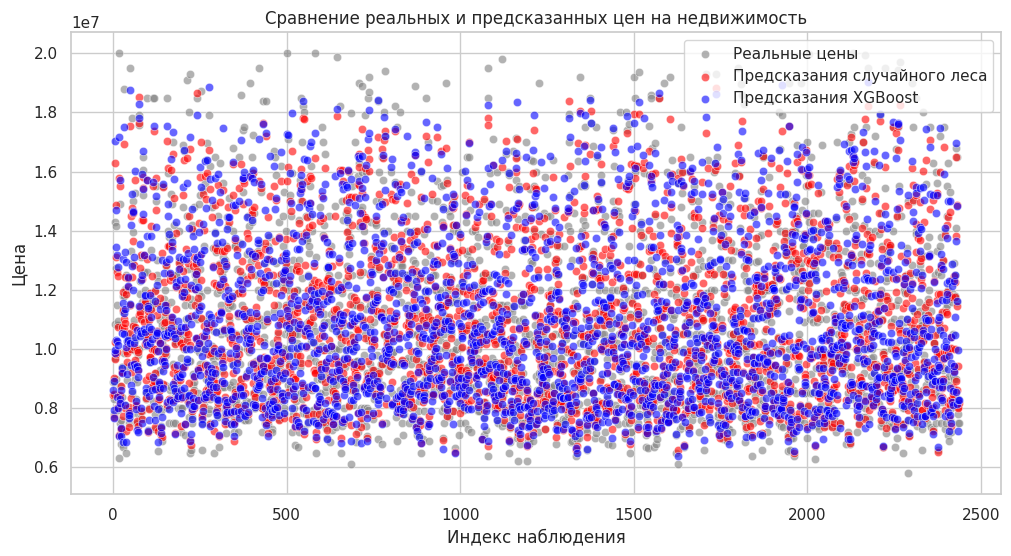

In [78]:
plt.figure(figsize=(12, 6))

# График реальных цен
sns.scatterplot(x=range(len(y_test)), y=y_test, color='gray', alpha=0.6, label='Реальные цены')

# График предсказанных цен случайным лесом
sns.scatterplot(x=range(len(y_test)), y=rf_predictions, color='red', alpha=0.6, label='Предсказания случайного леса')

# График предсказанных цен XGBoost
sns.scatterplot(x=range(len(y_test)), y=xgb_predictions, color='blue', alpha=0.6, label='Предсказания XGBoost')

plt.title('Сравнение реальных и предсказанных цен на недвижимость')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Цена')
plt.legend()
plt.show()

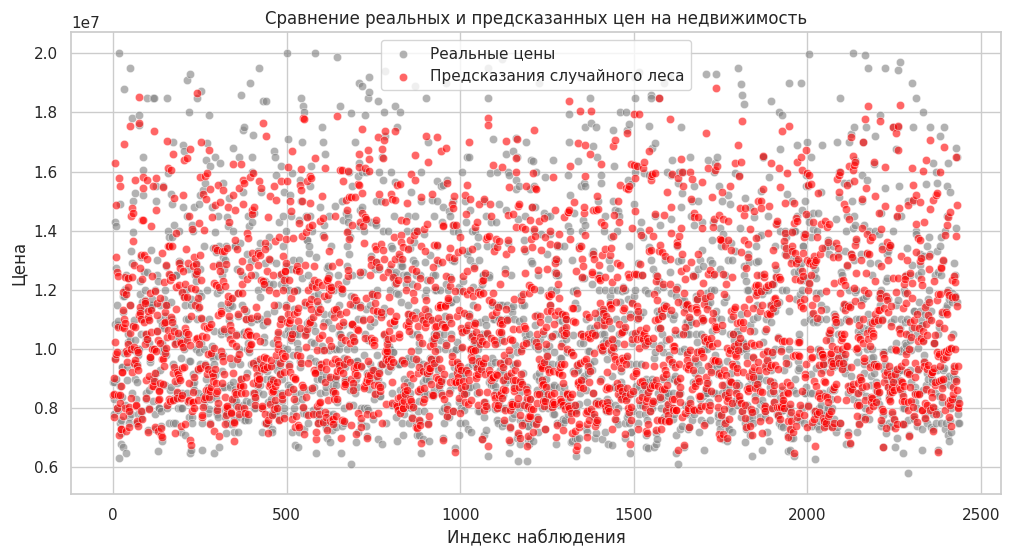

In [85]:
plt.figure(figsize=(12, 6))

# График реальных цен
sns.scatterplot(x=range(len(y_test)), y=y_test, color='gray', alpha=0.6, label='Реальные цены')

# График предсказанных цен случайным лесом
sns.scatterplot(x=range(len(y_test)), y=rf_predictions, color='red', alpha=0.6, label='Предсказания первого случайного леса')

plt.title('Сравнение реальных и предсказанных цен на недвижимость')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Цена')
plt.legend()
plt.show()

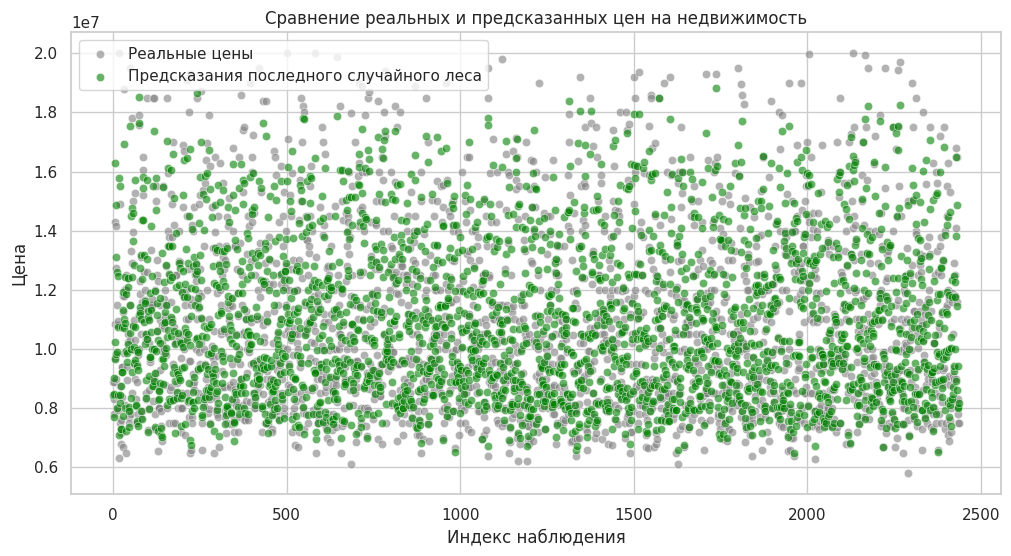

In [86]:
plt.figure(figsize=(12, 6))

# График реальных цен
sns.scatterplot(x=range(len(y_test)), y=y_test, color='gray', alpha=0.6, label='Реальные цены')

# График предсказанных цен случайным лесом
sns.scatterplot(x=range(len(y_test)), y=y_pred, color='green', alpha=0.6, label='Предсказания последного случайного леса')

plt.title('Сравнение реальных и предсказанных цен на недвижимость')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Цена')
plt.legend()
plt.show()

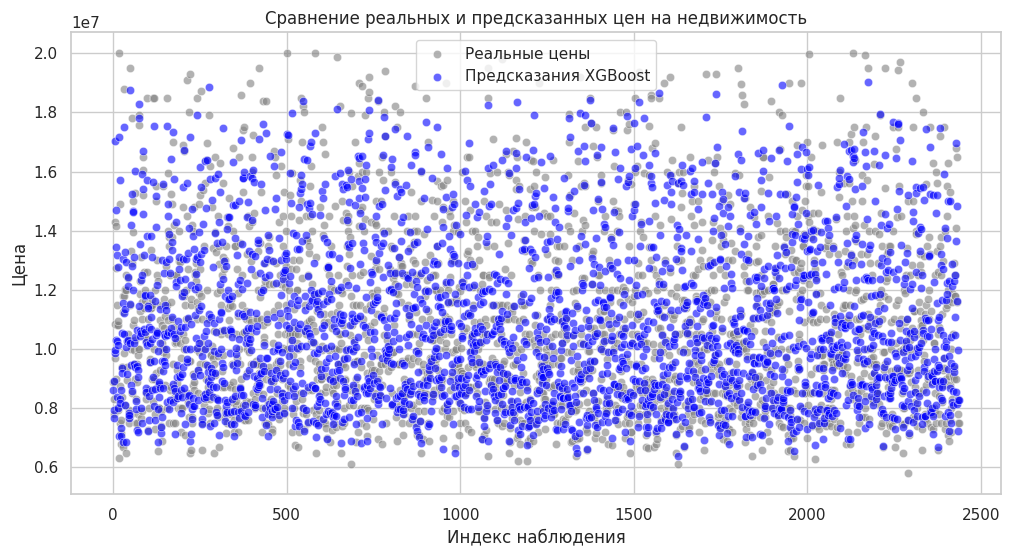

In [83]:
plt.figure(figsize=(12, 6))

# График реальных цен
sns.scatterplot(x=range(len(y_test)), y=y_test, color='gray', alpha=0.6, label='Реальные цены')

# График предсказанных цен XGBoost
sns.scatterplot(x=range(len(y_test)), y=xgb_predictions, color='blue', alpha=0.6, label='Предсказания XGBoost')

plt.title('Сравнение реальных и предсказанных цен на недвижимость')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Цена')
plt.legend()
plt.show()

### Предсказывание

#### Выбор случайной выборки

In [104]:
random_row = df.sample(1).iloc[0]
random_data_dict = random_row.to_dict()
default_price = None
if 'price' in random_data_dict:
    default_price = random_data_dict['price']
    del random_data_dict['price']
    
random_data_dict

{'repair': 2,
 'year_built_empty': 0,
 'house_age': 60,
 'closest_subway': 129,
 'dist_to_subway': 793,
 'sg': 0.0,
 'lat': 55.800068,
 'lon': 37.8070223,
 'subway_dist_to_center': 12418,
 'h3': '8611aa61fffffff',
 'agent_offers': 1,
 'subway_offers': 14,
 'address_offers': 1.0,
 'rooms': 2,
 'footage': 49.0,
 'floor': 2,
 'max_floor': 5,
 'first_floor': 0,
 'last_floor': 0,
 'AO': 'VAO',
 'hm': 'panel'}

REAL PRICE: 9500000
MODEL -> XGBOOST
Предсказанная цена: 9734622.00
MODEL -> First Random Forest
Предсказанная цена: 9367650.00
MODEL -> Final Random Forest
Предсказанная цена: 9558286.66
MODEL -> Gradient Boosting
Предсказанная цена: 9555420.27
MODEL -> Linear Regression
Предсказанная цена: 9194546.39


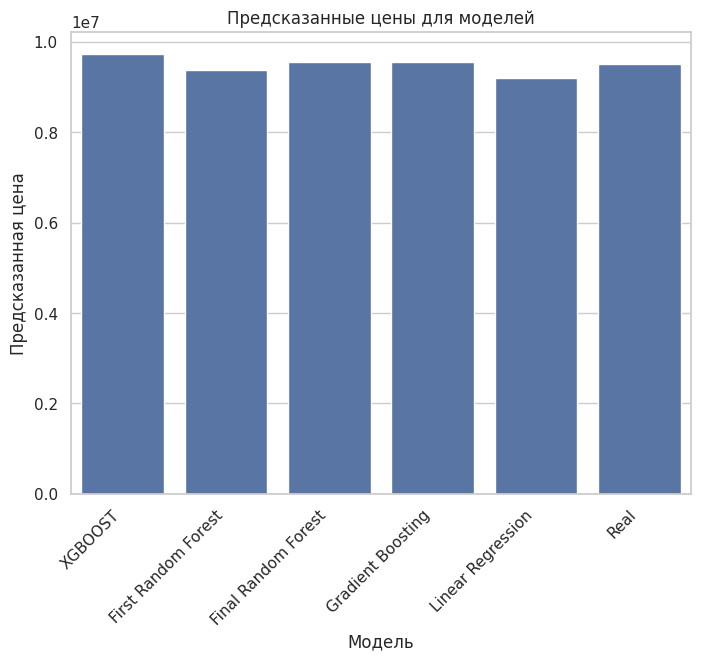

In [125]:
def make_prediction(input_data, model, preprocessor, name):
    input_df = pd.DataFrame([input_data])
    prepared_input = preprocessor.transform(input_df)
    prediction = model.predict(prepared_input)
    print(f"MODEL -> {name}")
    print(f"Предсказанная цена: {prediction[0]:.2f}")
    return prediction[0]

# Example input data
input_data = random_data_dict
print(f"REAL PRICE: {default_price}")

prediction_dict = {
    "XGBOOST": make_prediction(input_data, xgb_model, pipeline, "XGBOOST"),
    "First Random Forest": make_prediction(input_data, rf_model, pipeline, "First Random Forest"),
    "Final Random Forest": make_prediction(input_data, best_rf_model, pipeline, "Final Random Forest"),
    "Gradient Boosting": make_prediction(input_data, gb_model, pipeline, "Gradient Boosting"),
    "Linear Regression": make_prediction(input_data, linear_model, pipeline, "Linear Regression"),
    "Real" : default_price,
}

prediction_df = pd.DataFrame.from_dict(prediction_dict, orient="index", columns=["Predicted price"])

plt.figure(figsize=(8, 6))
sns.barplot(data=prediction_df, y="Predicted price", x=prediction_df.index)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Модель")
plt.ylabel("Предсказанная цена")
plt.title(f"Предсказанные цены для моделей")
plt.show()